In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from classes import Bandpasses, LightCurve, SNSurvey

In [3]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the LSST filters

In [4]:
bandpasses = Bandpasses()

Simulate a survey of SN1a

In [5]:
%%time
model = sncosmo.Model(source='salt2-extended')
params = {'z': 0, 't0': 0, 'x0': 1e-5, 'x1': 0.1, 'c': -0.1}
model.update(params)

survey = SNSurvey(model=model, area=5, cadence=2)
survey.simulate(bandpasses, norm=10)

print(survey)

SN Survey Simulation: 

    N obs = 3040  
     zmin = 0     
     zmax = 1     
     area = 5     
 duration = 1000.0
  cadence = 2     
flux errf = 0.05  

Model: 
source:
  class      : SALT2Source
  name       : 'salt2-extended'
  version    : 2.0
  phases     : [-20, .., 50] days
  wavelengths: [1700, .., 24990] Angstroms
parameters:
  z  = 0.0
  t0 = 0.0
  x0 = 1e-05
  x1 = 0.1
  c  = -0.1
CPU times: user 22.9 s, sys: 54.8 ms, total: 23 s
Wall time: 23 s


Print the first observation as an example?

In [6]:
print(survey.obs[0])

SkyObject Observation: 

     source = SN1a  
         t0 = 59813.3463
     spec-z = 0.9029
    photo-z = None  
photo-z err = None  
      N obs = 35    

   mjd     filter   flux   flux_err
---------- ------ -------- --------
59795.2266  lssti 0.017789 0.000918
59797.4051  lsstz 0.174505 0.009137
59799.3432  lssty 0.534315 0.027534
59801.3943  lsstu 0.417038 0.022418
59803.1839  lsstg 1.788584 0.100117
59805.0759  lsstr 4.086656 0.206042
       ...    ...      ...      ...
59853.5295  lsstr 0.206595 0.010516
59855.3481  lssti 0.344028 0.018295
59857.2902  lsstz 0.397819 0.019795
59859.4348  lssty 0.392359 0.020211
59861.5346  lsstu 0.001045    5e-05
59863.3183  lsstg 0.066145   0.0034
Length = 35 rows


Plot the flux of the SALT2 model the survey is simulated from

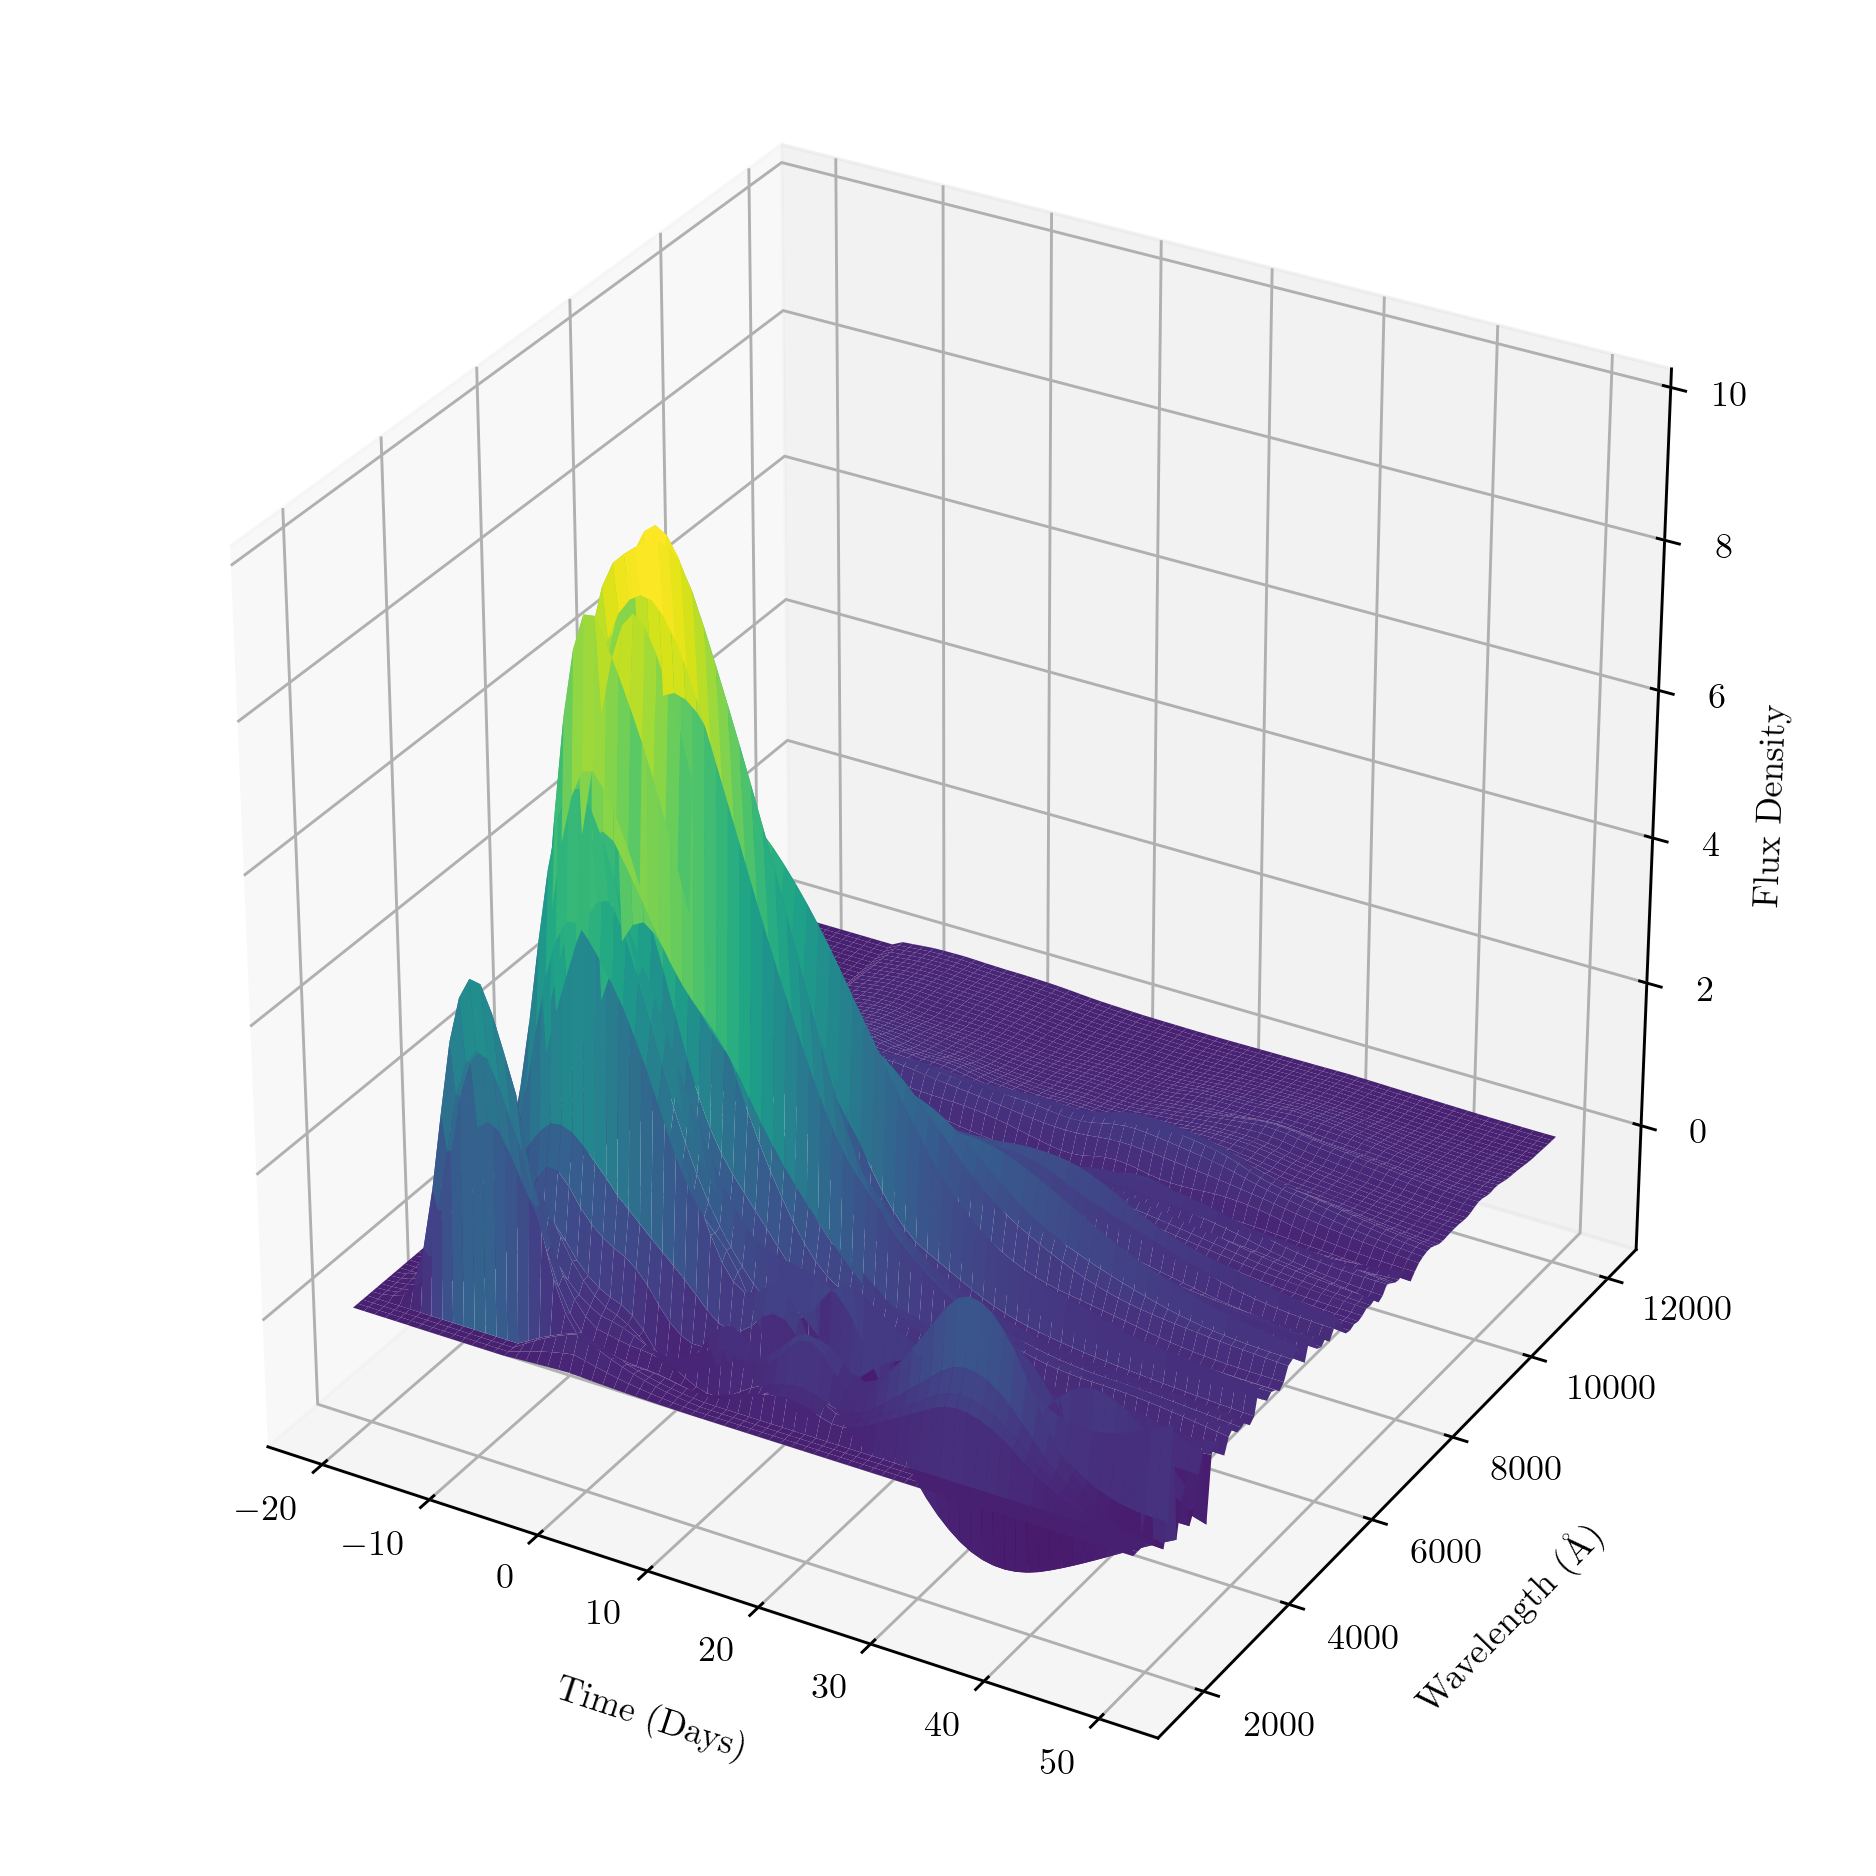

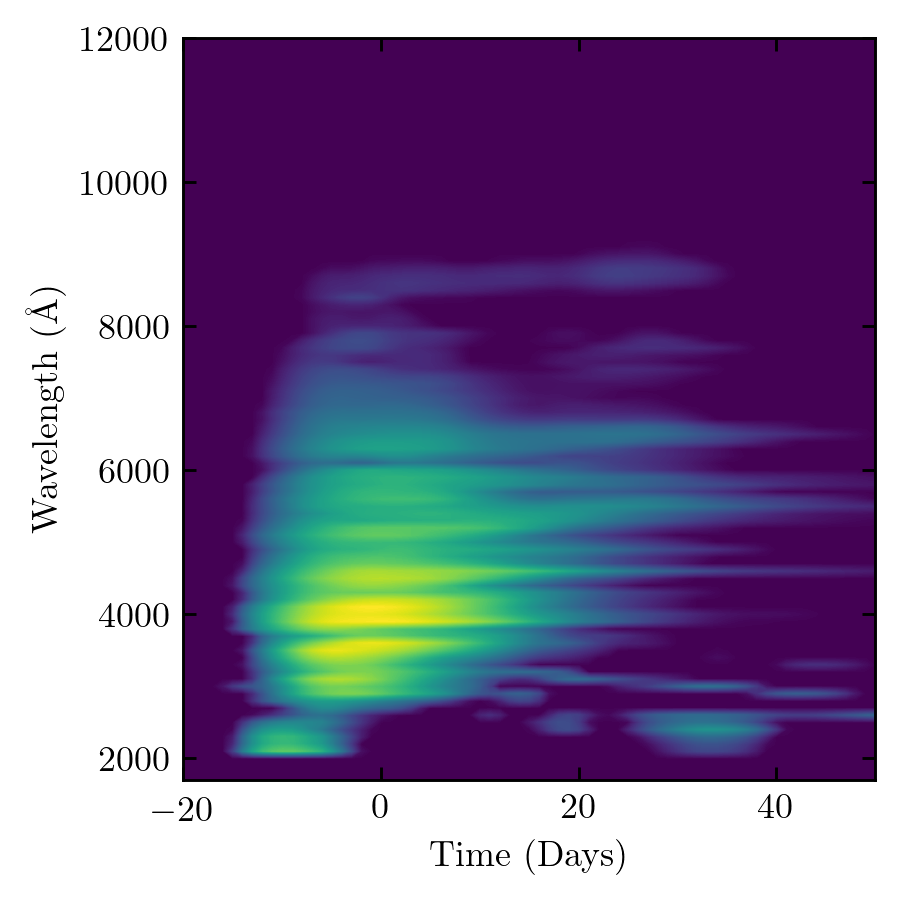

In [7]:
time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 12100, 100)
lc = LightCurve(time, wavelen)
lc.from_model(model)
fig = lc.surface_plot()
fig = lc.contour_plot()

Now we start with a totally null light curve

In [8]:
time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 12100, 100)
lcn = LightCurve(time, wavelen)
lcn.null()

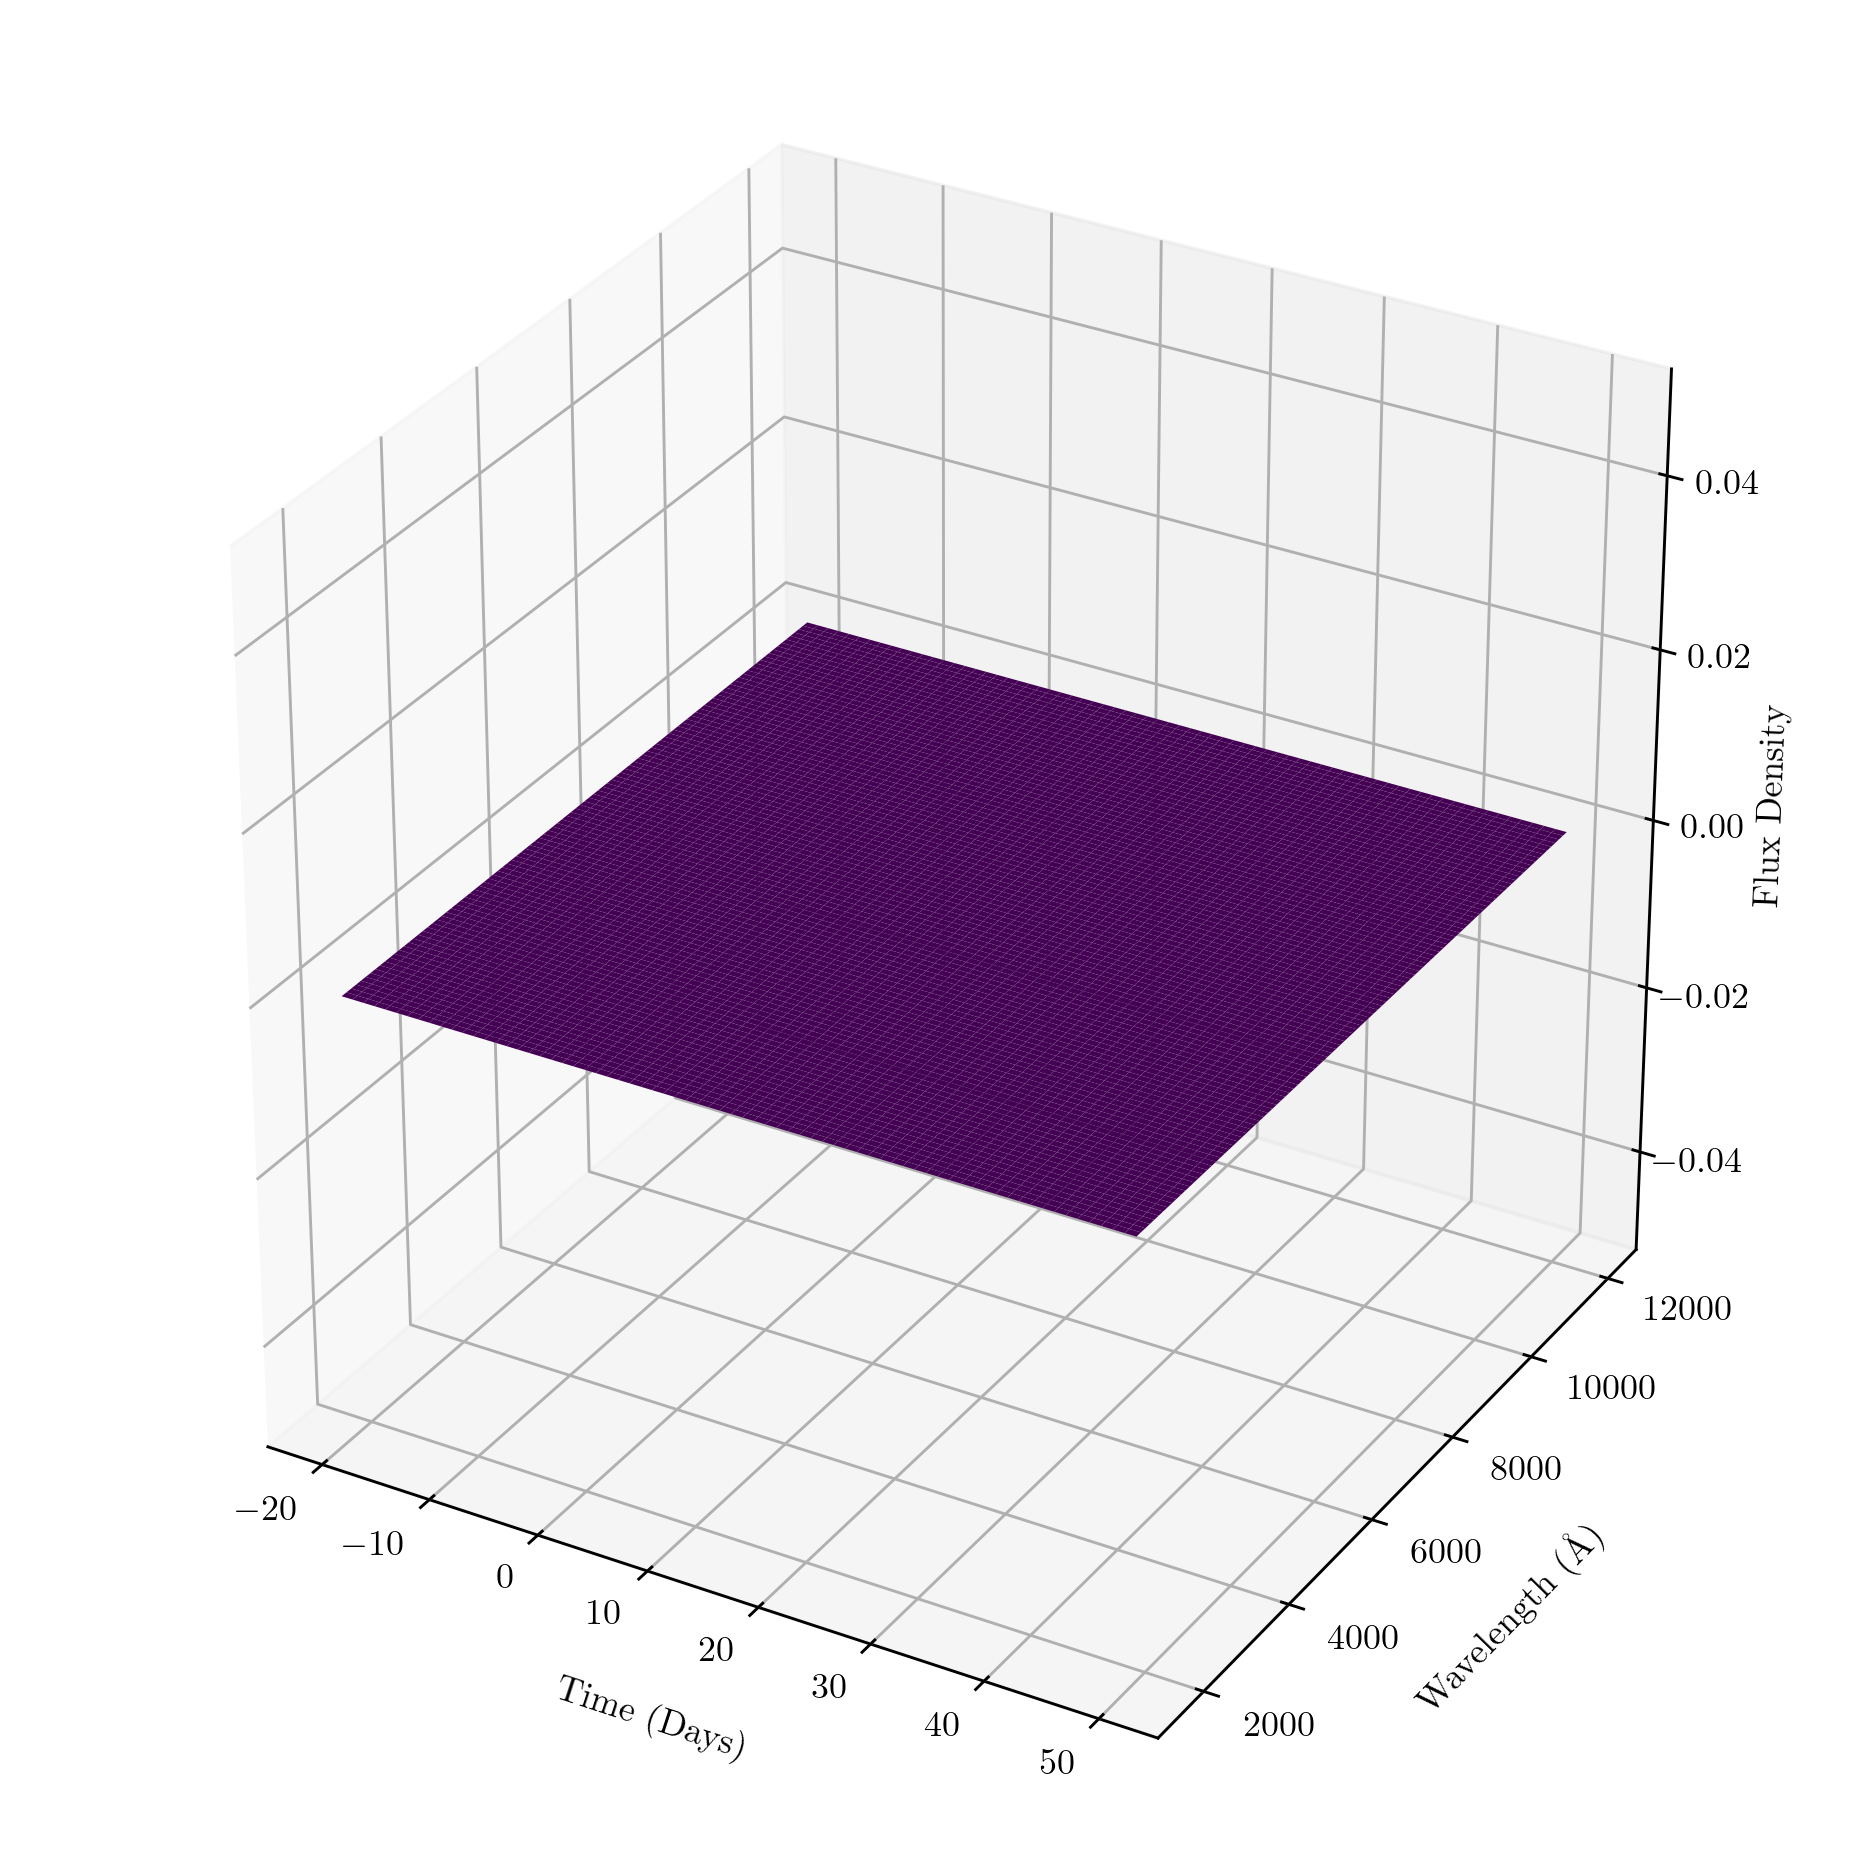

In [9]:
fig = lcn.surface_plot()

Now train the light curve on the photometry in the simulated survey

In [10]:
%time training_sets = lcn.training_sets(survey.obs)

CPU times: user 47.3 s, sys: 376 ms, total: 47.7 s
Wall time: 47.7 s


In [11]:
%time lcn.train(training_sets, bandpasses, w=0.01, dmse_stop=0.01)

CPU times: user 17.4 s, sys: 664 ms, total: 18 s
Wall time: 1min 19s


Now plot the results!

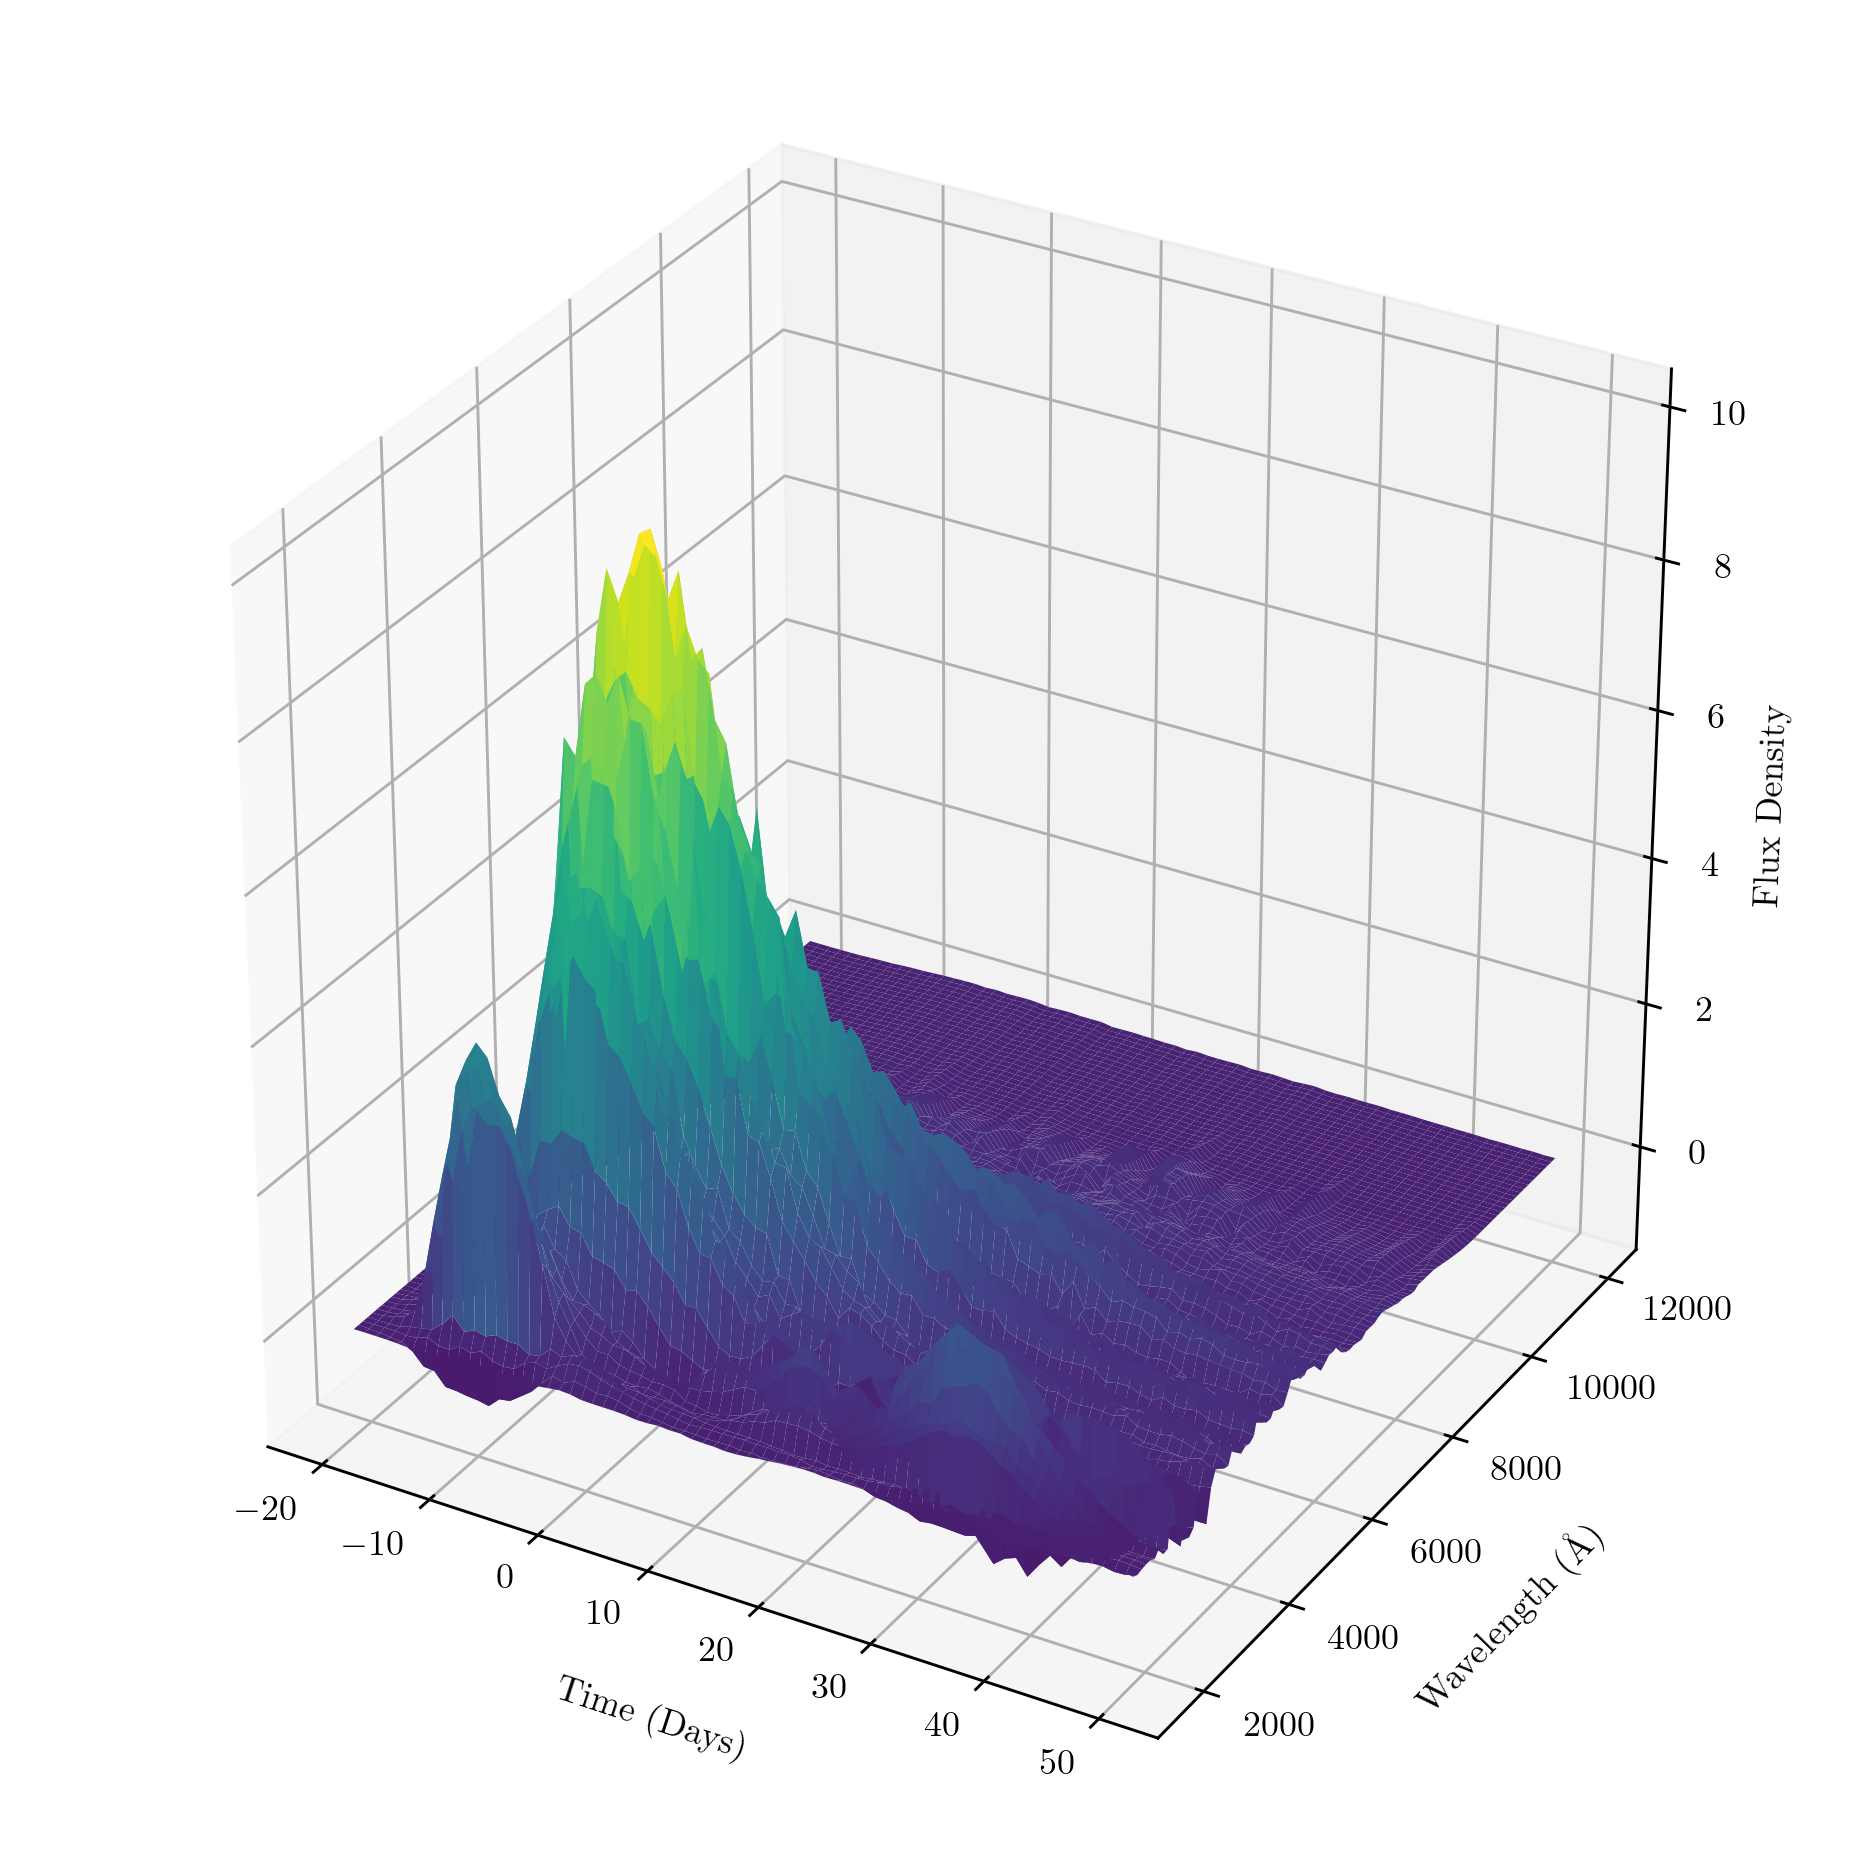

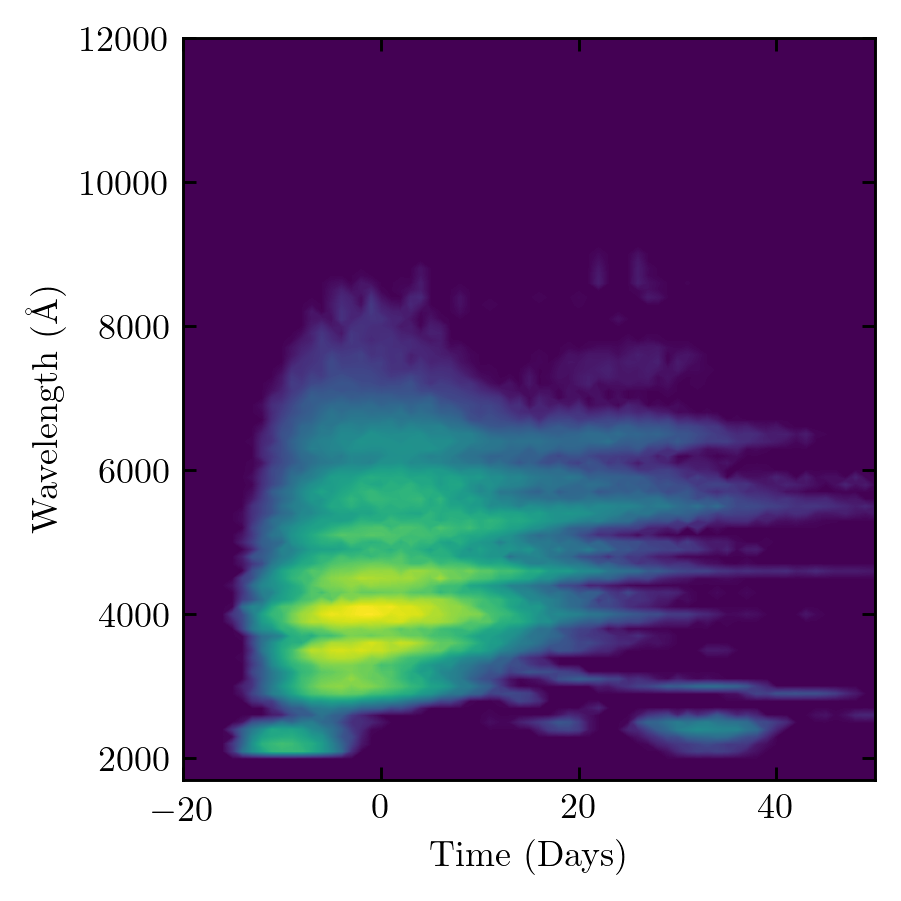

In [12]:
fig = lcn.surface_plot()
fig = lcn.contour_plot()

Now I will make comparison plots. I plot the surfaces and contours side by side, and make a plot of the residuals.

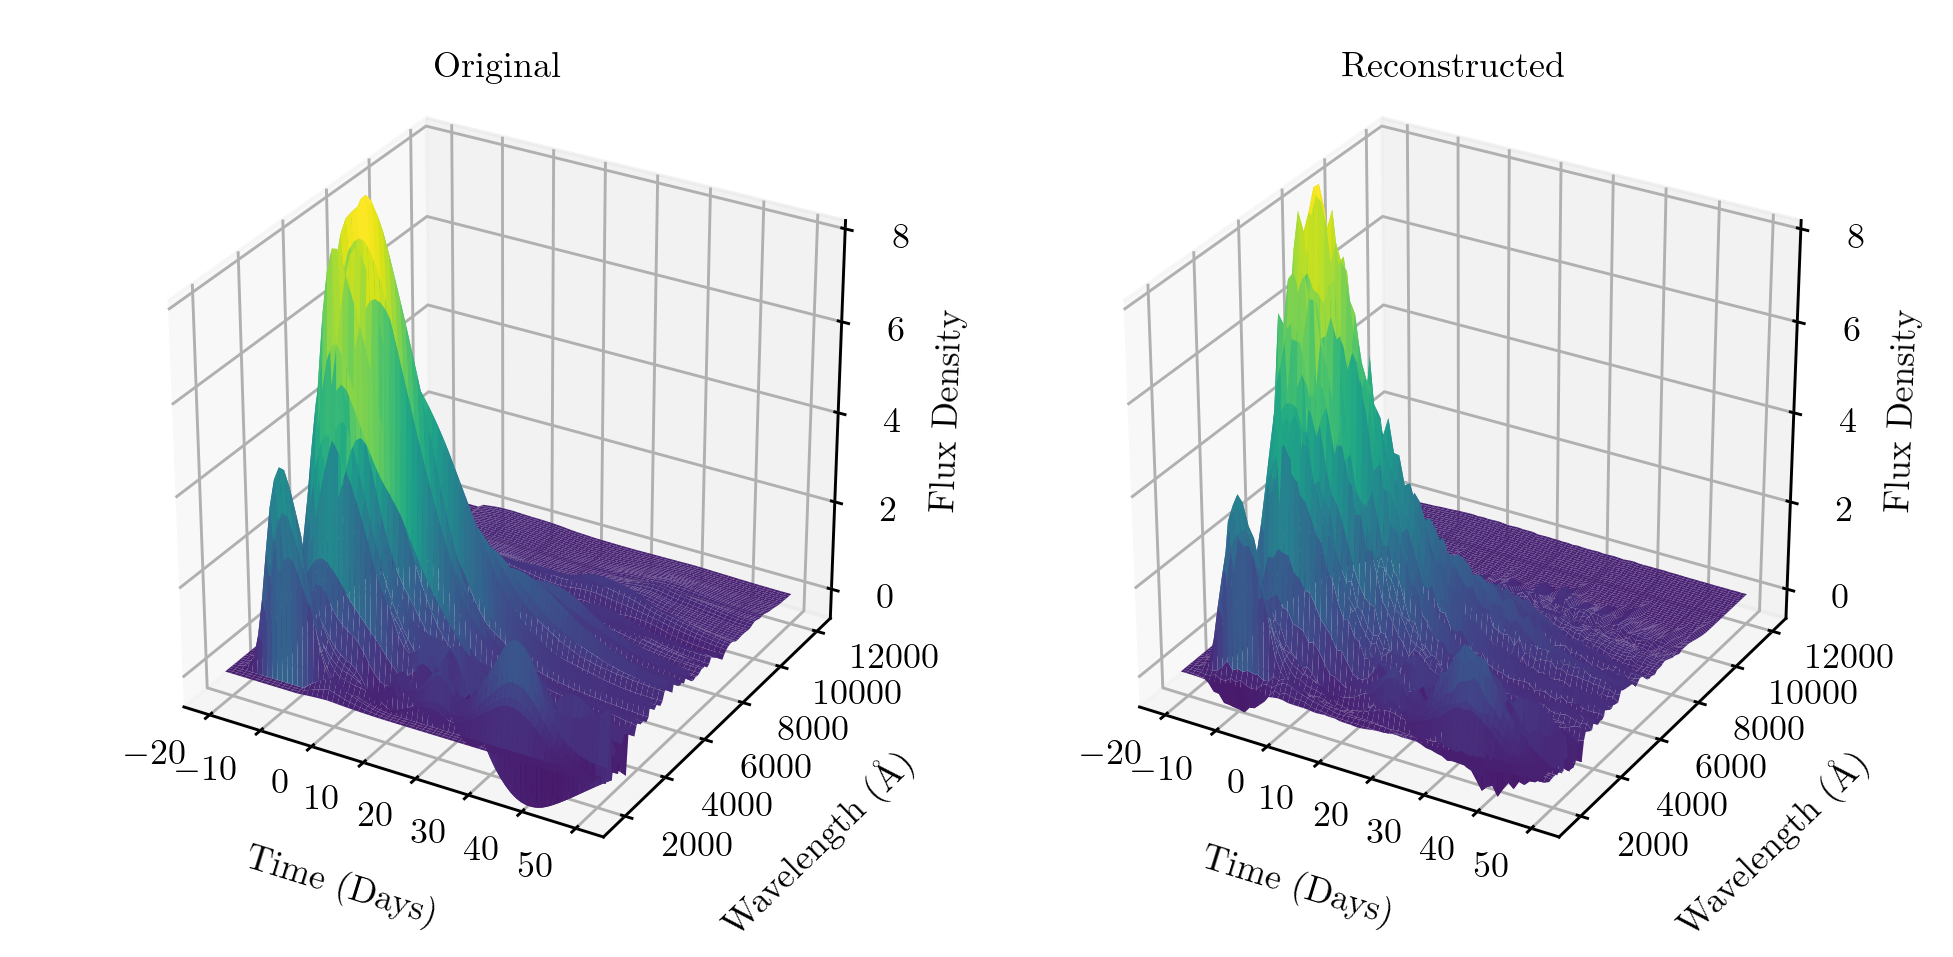

In [14]:
fig = plt.figure(figsize=(twocol,onecol))

x, y = np.meshgrid(lc.time, lc.wavelen)

ax = fig.add_subplot(1,2,1, projection='3d')
ax.dist = 11
ax.plot_surface(x, y, lc.flambda, cmap='viridis', rcount=200, ccount=200)
ax.set_zlim(-0.5, 8)
plt.setp( ax.xaxis.get_majorticklabels(), va="bottom", ha='right' )
plt.setp( ax.yaxis.get_majorticklabels(), va="bottom", ha='left' )
ax.set_xlabel("Time (Days)", ha='left')
ax.set_ylabel("Wavelength ($\mathrm{\AA}$)", labelpad=10)
ax.set_zlabel("Flux Density", labelpad=2)
ax.set_title("Original")

ax = fig.add_subplot(1,2,2, projection='3d')
ax.dist = 11
ax.plot_surface(x, y, lcn.flambda, cmap='viridis', rcount=200, ccount=200)
ax.set_zlim(-0.5, 8)
plt.setp( ax.xaxis.get_majorticklabels(), va="bottom", ha='right' )
plt.setp( ax.yaxis.get_majorticklabels(), va="bottom", ha='left' )
ax.set_xlabel("Time (Days)")
ax.set_ylabel("Wavelength ($\mathrm{\AA}$)", labelpad=10)
ax.set_zlabel("Flux Density", labelpad=2)
ax.set_title("Reconstructed")

plt.subplots_adjust(wspace=0.01,top=1.07,bottom=0.03,left=-0.04,right=0.99)
fig.savefig('plots/surface_comparison.png')

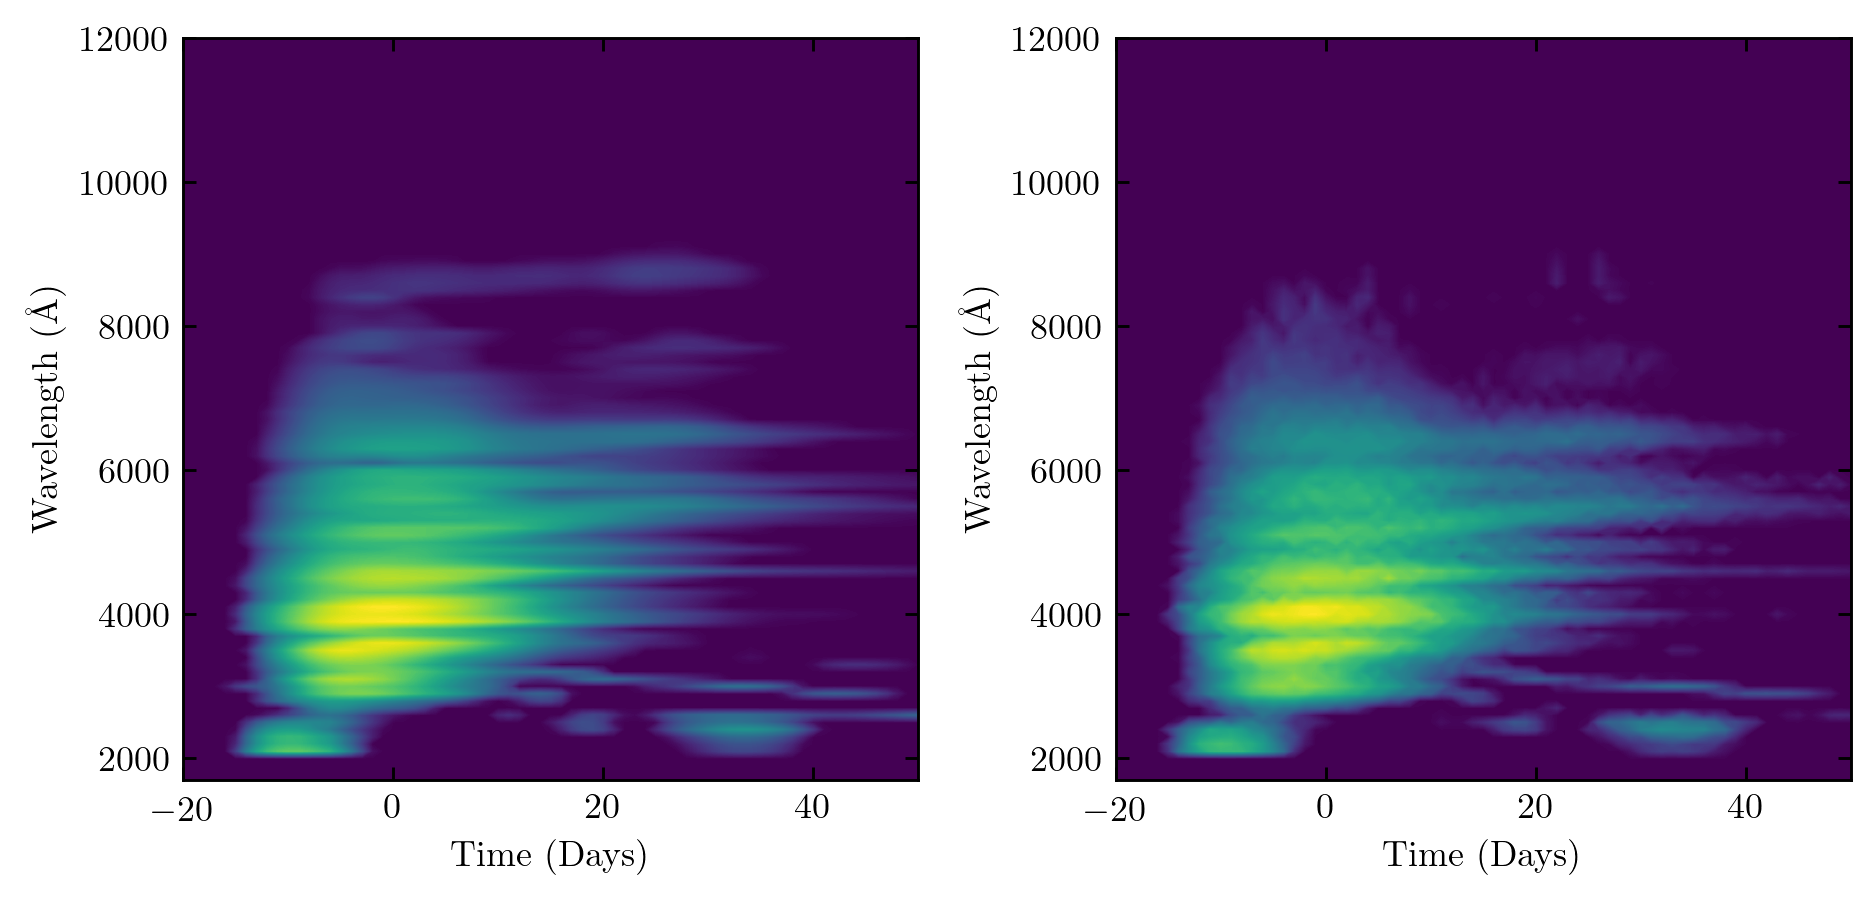

In [15]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(twocol,onecol),constrained_layout=True)

x,y = np.meshgrid(lc.time, lc.wavelen)

zcut = np.max(lc.flambda)/20
z = np.log10( np.clip(lc.flambda, zcut, None) )
ax1.contourf(x, y, z, levels=200)
ax1.set_xlabel("Time (Days)")
ax1.set_ylabel("Wavelength ($\mathrm{\AA}$)")

zcut = np.max(lcn.flambda)/20
z = np.log10( np.clip(lcn.flambda, zcut, None) )
ax2.contourf(x, y, z, levels=200)
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Wavelength ($\mathrm{\AA}$)")

fig.savefig('plots/contour_comparison.png')

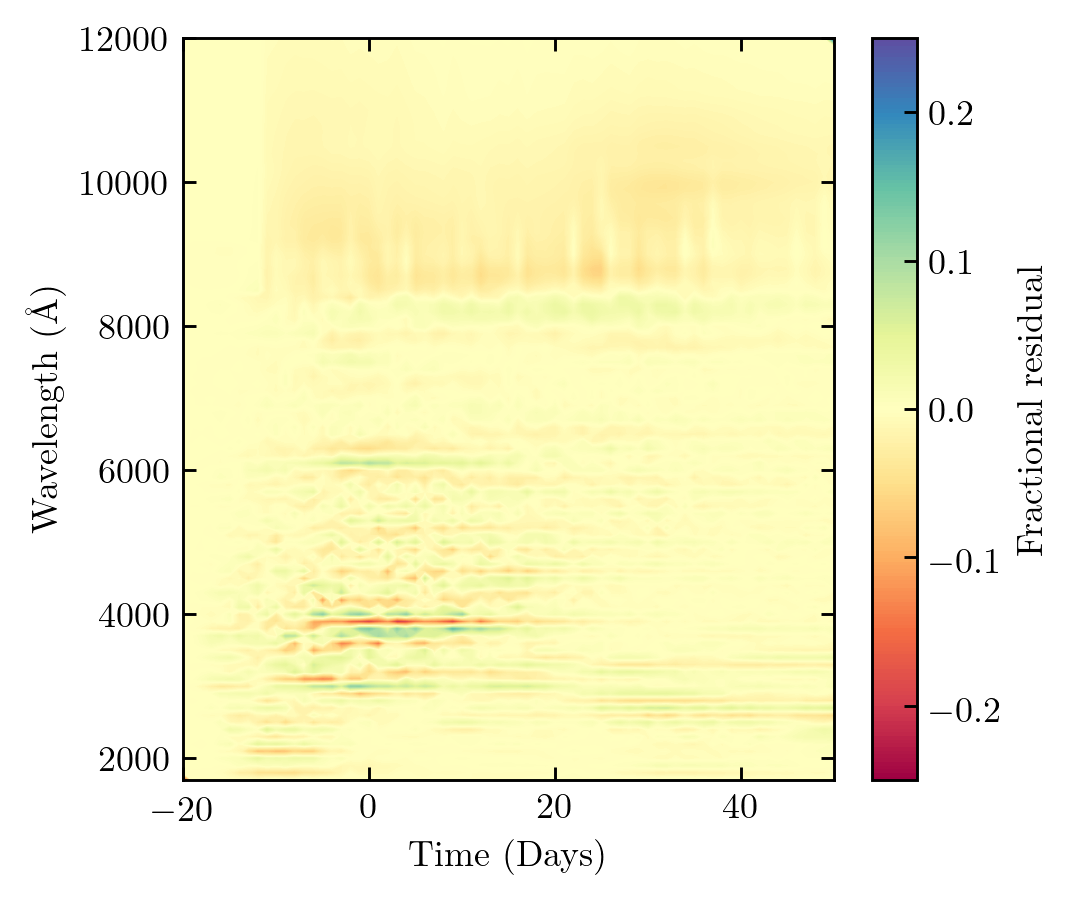

In [16]:
fig,ax = plt.subplots(figsize=(1.2*onecol,onecol), constrained_layout=True)

z = (lcn.flambda - lc.flambda)/np.max(lc.flambda)
z[0,0], z[-1,-1] = -0.25, 0.25
cont = ax.contourf(lc.time, lc.wavelen, z, cmap='Spectral', vmin=-0.25, vmax=0.25, levels=200)
fig.colorbar(cont, ticks=[-0.2,-0.1,0,0.1,0.2], label='Fractional residual')
ax.set_xlabel("Time (Days)")
ax.set_ylabel("Wavelength ($\mathrm{\AA}$)")

fig.savefig('plots/residuals.png')
plt.show()